In [26]:
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import rasterio.plot
from pyproj import Transformer
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn.linear_model import LinearRegression
import csv

In [27]:
# Datetime to decimal year
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

# Find the position of the k nearest elements in a 1d array to a value
def find_nearest(array, value, k):
    array = np.asarray(array)
    idx = np.argpartition(np.abs(array - value), k)
    return idx[:k]

# Get data column from SERAC dat file using the converted data format
def get_SERAC_column(header, SERAC_d, col_ind):
    h = []
    for i in header[0]:
        h1 = []
        for record in SERAC_d[i]:
            h1.append(record[col_ind])
        h.append(np.array(h1))
    return h

# Third order polynomial interpolation
def poly_interp(time, y, deg = 3):   
    model = np.poly1d(np.polyfit(time, y, deg))

    x_pred = np.linspace(time[0], time[-1], int((time[-1]-time[0])*100))
    y_pred = model(x_pred)
    
    return x_pred, y_pred

# Total dynamic ice thickness change = total elevation change -  elevation change due to FDM
def total2dynamicH_direct(h_t, h_fdm):
    h_fdm = h_fdm - h_fdm[0]
    h_d = h_t - h_fdm
    return h_d

# Error propation of partitioning
def error_prop_add_direct(err_relh, err_fdm):
    err_fdm_dif = np.sqrt(err_fdm**2+err_fdm[0]**2)
    err = np.sqrt(err_relh**2+err_fdm_dif**2)
    return err

In [28]:
# File directions
SERAC_dir = "/Users/huigao/Desktop/Mass_reconstruction/Annual_thickness_reconstruction/Partition_SERAC2022/"
FDM_IMAU2020_dir = "/Volumes/Samsung_T5/Greenland_climatology/RACMO/IMAUFDM_RACMO2.3p2_1960-2020/"

# Switch to determine use converted CSV FDM or original netcdf file
useCSV = True

In [29]:
## Read in the SERAC data and convert it to format of pandas dataframe

tile_id = 26

# Read in the txt and skip the first two rows of tile information
df = pd.read_table(SERAC_dir+"TimeSeriesTile"+str(tile_id)+".txt", sep = "\s+", skiprows = [0, 1]) 

# Pandas takes the first row as column names, extract colomn names and merge it with the dataframe as a record
row1 = np.array(df.columns)
row1 = np.insert(row1, 0, np.NaN)
df0 = pd.DataFrame(data = row1.reshape(1,-1))
df = df.reset_index(drop = False)
df.columns = range(df.columns.size)
df = pd.concat([df0 ,df]).reset_index(drop = True)
df = df.drop(columns=[0])
df.head()

,1,2,3,4,5,6,7,8,9,10
0,7000003,21,0,323930.320,7934825.490,2777.864,332.54,0.037,0.033,83020
1,L1A,2003.1589,22703,-210.1,-0.204,0.017,2777.604,6.0,0.0,NaN
2,L1A,2003.1808,30703,-209.767,-0.147,0.016,2777.661,6.0,0.0,NaN
3,L1A,2003.2027,31503,-209.5,-0.043,0.023,2777.765,6.0,0.0,NaN
4,L1A,2003.2247,32303,-209.233,-0.141,0.023,2777.668,6.0,0.0,NaN


In [30]:
## Seperate data (SERAC_d) from surface patch information (header)

SERAC_d = {}
row = []
header = []
for i in range(len(df)):
    if df.values[i,0][0] == str(tile_id)[0]:
        id_pts = str(df.values[i,0])
        header.append(df.values[i,:])
        row = []
    else:
        row.append(df.values[i,:])
        SERAC_d[id_pts] = row

header = pd.DataFrame(np.array(header))


# Keep integers in the original SERAC file as integer in the dataframe
for i in range(len(header)):
    header.iloc[i,1] = int(header.iloc[i,1])
    header.iloc[i,-1] = int(header.iloc[i,-1])

# Delete the padding NaNs in SERAC data
for i in range(len(SERAC_d)):
    SERAC_d[header[0][i]] = np.delete(SERAC_d[header[0][i]], -1, 1)
    
header.head()

,0,1,2,3,4,5,6,7,8,9
0,7000003,21,0,323930.320,7934825.490,2777.864,332.54,0.037,0.033,83020
1,7000005,18,0,92313.42,7923289.19,1362.577,257.99,0.229,0.224,83020
2,7000006,19,0,92911.84,7910990.97,1338.868,489.04,0.869,0.853,83020
3,7000007,46,0,281828.65,7903497.14,2591.04,220.77,0.046,0.045,83020
4,7000008,21,0,311210.11,7896448.76,2686.744,9038.91,0.054,0.053,83020


In [31]:
## Detect outlier and create flags

time = get_SERAC_column(header, SERAC_d, 1)
rel_h = get_SERAC_column(header, SERAC_d, 4)

outlier_flag = []
for i in range(len(rel_h)):
    x_pred, y_pred = poly_interp(time[i], rel_h[i])
    interp_ts = pd.Series(data=y_pred, index=np.round(x_pred, 2))
    interp_ts = interp_ts.reindex(time[i], method = 'nearest')
    resid = rel_h[i] - interp_ts.values
    outlier_msk_mad = (np.abs(resid - np.median(resid))/np.median(np.abs(resid - np.median(resid)))) < 3.5
    outlier_msk_std = np.abs(resid - np.median(resid)) < 3*np.std(resid)
    
    # Outliers are those whose residuals of polynomial interpolation are outside of the 3 standard deviations from the median of the residuals
    outlier_flag.append(outlier_msk_std) 

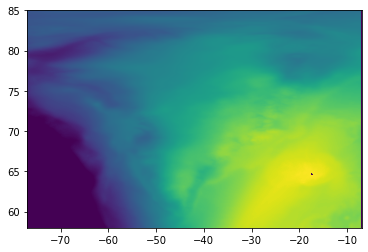

,0,1,2,3,4,5,6,7,8,9,lon,lat,geoid
0,7000003,21,0,323930.320,7934825.490,2777.864,332.54,0.037,0.033,83020,-43.963676,71.450029,39.789400
1,7000005,18,0,92313.42,7923289.19,1362.577,257.99,0.229,0.224,83020,-50.317129,71.068650,31.381300
2,7000006,19,0,92911.84,7910990.97,1338.868,489.04,0.869,0.853,83020,-50.238329,70.961503,31.358000
3,7000007,46,0,281828.65,7903497.14,2591.04,220.77,0.046,0.045,83020,-45.054810,71.136101,38.996401
4,7000008,21,0,311210.11,7896448.76,2686.744,9038.91,0.054,0.053,83020,-44.227183,71.097711,39.393499


In [32]:
## Transform SERAC coordinates to WGS84

lon = []
lat = []
transformer = Transformer.from_crs("epsg:32624", "epsg:4326", always_xy=True)

for i in range(len(header)):
    X = header.iloc[i,3]
    Y = header.iloc[i,4]
    lon1, lat1 = transformer.transform(X, Y)
    lon.append(lon1)
    lat.append(lat1)

header['lon'] = lon
header['lat'] = lat



## Read geoid data and plot

fn = SERAC_dir+'Greenland16/ggeoid16.tif'
geoid_GIS= rasterio.open(fn)
geoid = geoid_GIS.read(1)
rasterio.plot.show(geoid, transform=geoid_GIS.transform, cmap='viridis', vmin = 0, aspect = 'auto')
plt.show()



## Get geoid coordinates and find the geoid heights at locations of SERAC surface patches

lon_geoid = []
for i in range(geoid_GIS.width):
    lon_geoid.append(geoid_GIS.xy(0,i)[0])
lat_geoid = []
for i in range(geoid_GIS.height):
    lat_geoid.append(geoid_GIS.xy(i,0)[1])
    
geoid_SERAC = []
for j in range(len(header)):
    ind_lat = find_nearest(lat_geoid, header['lat'][j], 1).item()
    ind_lon = find_nearest(lon_geoid, header['lon'][j], 1).item()
    # The geoid has been shifted by -15.6 cm from the global WGS84 computation system, to match ASIAQ mean sea level at Nuuk.
    geoid_SERAC.append(geoid[ind_lat,ind_lon]+0.156)
    
header['geoid'] = geoid_SERAC
header.head()

In [33]:
## Create flags: 1 = good data, 2 = outlier, 3 = good data, but at sea-level, 
## 4 = outlier at sea-level (could be false outlier as the polynomial interpolation can't catch the drop of surface elevation to sea-level)

time = get_SERAC_column(header, SERAC_d, 1)
absh = get_SERAC_column(header, SERAC_d, 6)
err_relh = get_SERAC_column(header, SERAC_d, 5)

flags = []
for i in range(len(absh)):
    flag = outlier_flag[i]*1
    flag[flag==0] = 2
    
    if np.any(absh[i]<(header['geoid'][i]+10)): # Measurements within 10 m of GEOID height are identified as at sea-level
        sl_msk = (absh[i]<(header['geoid'][i]+10))*1
        flags.append(flag + sl_msk*2)
        
        fig = plt.figure(figsize = (15,5))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.scatter(time[i], absh[i], c = 'red')
        plt.errorbar(time[i], absh[i], yerr = err_relh[i], color='grey', linestyle='')
        ax1.set_xticks(np.arange(int(time[i][0]), int(time[i][-1]+2), 2))
        ax1.tick_params(axis='x', rotation=45)
        ax1.set_title(header[0][i]+' GEOID height: '+str(np.round(header['geoid'][i], 2)), fontsize = 22)
        ax1.set(xlabel=None, ylabel=None)
    else:
        flags.append(flag)

In [34]:
%%time

## Use FDM netcdf file
## Find the n_n nearest neighbors in FDM and get the mean and standard deviation

stop = False

if not useCSV:
    FDM = xr.open_dataset(FDM_IMAU2020_dir+"FDM_zs_FGRN055_1957-2020_GrIS_GIC.nc")
    
    time = FDM['time'].values
    time_decimal = []
    for t in time:
        time_decimal.append(year_fraction(pd.Timestamp(t).to_pydatetime()))
    time = np.array(time_decimal)


    # Coordinate transformation: lat, lon (epsg4326) TO X, Y (epsg32624)
    transformer = Transformer.from_crs("epsg:4326", "epsg:32624", always_xy=True)
    lon = FDM.lon.values.reshape(-1)
    lat = FDM.lat.values.reshape(-1)
    X, Y = pd.Series(transformer.transform(lon, lat))
    X = X.reshape(FDM.lon.values.shape)
    Y = Y.reshape(FDM.lat.values.shape)



    ## Find the index of FDM closets to the SERAC reconstructions

    k = 10 # Sort the biggest kth elements in an array. k should be at least equal to n_n, because the netcdf file of FDM contains grids of NaNs
    n_n = 4 # Number of nearest neighbors to be selected
    ind_ls = []
    for i in range(len(header)):
        ind_fla = np.argpartition((np.square(X - float(header[3][i])) + np.square(Y - float(header[4][i]))).flatten(), tuple(range(0,k)))[:k]
        
        ind_near = []
        c = 0
        n = 0
        while n < k:
            ind = divmod(ind_fla[n], FDM['lat'].values.shape[1])
            if not np.isnan(FDM['zs'].values[:, ind[0], ind[1]]).any():
                ind_near.append(ind)
                c = c+1
                if c == n_n:
                    break # Finish searching after found n_n nearest neighbors without NaNs
            n = n+1
            
        if c < n_n:
            stop = True # If less than n_n nearest neighbors are selected, stop runnnig the rest of the code in the cell
            print("Only "+str(c)+" nearest neighbors are selected at the "+str(i)+"th location:\n"+
                  str(k-c)+" of the "+str(k)+" nearest neighbors contains NaN.\nPlease increase the value of k.")
        ind_ls.append(np.array(ind_near))

    if not stop:
        # Find errors of positoin: SERAC centroid to FDM centroid
        x_err = []
        y_err = []
        for i in range(len(ind_ls)):
            x_err1 = []
            y_err1 = []
            for j in range(len(ind_ls[i])):
                x_err1.append(X[ind_ls[i][j][0], ind_ls[i][j][1]] - float(header[3][i]))
                y_err1.append(Y[ind_ls[i][j][0], ind_ls[i][j][1]] - float(header[4][i]))
            x_err.append(np.array(x_err1))
            y_err.append(np.array(y_err1))

        mean_x_err = []
        mean_y_err = []
        for i in range(len(ind_ls)):
            mean_x_err.append(np.mean(x_err[i]))
            mean_y_err.append(np.mean(y_err[i]))


        ## Extract time series of FDM
        fdm_serac = []
        fdm_serac_std = []
        for i in range(len(ind_ls)):
            h1 = []
            for j in range(len(ind_ls[i])):
                h1.append(FDM['zs'].values[:, ind_ls[i][j][0], ind_ls[i][j][1]])
            fdm_serac.append(h1[0])
            fdm_serac_std.append(np.std(np.array(h1), axis = 0))
    

CPU times: user 4 µs, sys: 12 µs, total: 16 µs
Wall time: 19.3 µs


In [35]:
%%time

## Use FDM csv file
## Find the nearest neighbor in FDM and normalization

if useCSV:
    FDM_fcsv = pd.read_csv(FDM_IMAU2020_dir+"FDM_zs_FGRN055_1957-2020_GrIS_GIC_SERACInput.csv", na_values=-999.0) 
    time = np.array(FDM_fcsv.columns[4:], dtype = float)


    ## Find the index of FDM closets to the SERAC reconstructions
    n_n = 4 # Number of nearest neighbors to be selected
    ind_ls = []
    for i in range(len(header)):
        ind_arr = np.argpartition((np.square(FDM_fcsv['X'].values - float(header[3][i])) + np.square(FDM_fcsv['Y'].values - float(header[4][i]))), tuple(range(0,n_n)))[:n_n]
        ind_ls.append(np.array(ind_arr))
        
    # Find errors of positoin: SERAC centroid to FDM centroid
    x_err = []
    y_err = []
    for i in range(len(ind_ls)):
        x_err1 = []
        y_err1 = []
        for j in range(len(ind_ls[i])):
            x_err1.append(FDM_fcsv['X'].values[ind_ls[i][j]] - float(header[3][i]))
            y_err1.append(FDM_fcsv['Y'].values[ind_ls[i][j]] - float(header[4][i]))
        x_err.append(np.array(x_err1))
        y_err.append(np.array(y_err1))

    mean_x_err = []
    mean_y_err = []
    for i in range(len(ind_ls)):
        mean_x_err.append(np.mean(x_err[i]))
        mean_y_err.append(np.mean(y_err[i]))


    ## Extract time series of FDM
    fdm_serac = []
    fdm_serac_std = []
    for i in range(len(ind_ls)):
        h1 = []
        for j in range(len(ind_ls[i])):
            h1.append(FDM_fcsv.iloc[ind_ls[i][j], 4:])
        fdm_serac.append(h1[0])
        fdm_serac_std.append(np.std(np.array(h1), axis = 0))

CPU times: user 26.3 s, sys: 4.49 s, total: 30.7 s
Wall time: 34.3 s


In [ ]:
## Example plot surface height change due to FDM at the kth surface patch

k = 0
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(time, fdm_serac[k], c = 'r', label = 'Mean')
ax.fill_between(time, fdm_serac[k]-fdm_serac_std[k], fdm_serac[k]+fdm_serac_std[k], facecolor ='grey')
ax.set_xlabel('Date',fontsize = 13)
ax.set_ylabel('zs (m)', fontsize=13)
ax.set_title('surface height due to SMB and firn compaction relative to (1960-1979)', fontsize=15)
ax.legend()
ax.grid(True)

In [36]:
## Save FDM to text file

with open(SERAC_dir+"FDMTile"+str(tile_id)+".txt", 'w', encoding='UTF8') as f:
    # write the header line
    f.write(",".join(str(item) for item in time))
    f.write("\n")

    # write FDM records
    for i in range(len(fdm_serac)):
        f.write(",".join(str(np.round(item, 3)) for item in fdm_serac[i]))
        f.write("\n")
        
        

## Save FDM standard deviation to text file

with open(SERAC_dir+"FDMstdTile"+str(tile_id)+".txt", 'w', encoding='UTF8') as f:
    # write the header line
    f.write(",".join(str(item) for item in time))
    f.write("\n")

    # write FDM standard deviation records
    for i in range(len(fdm_serac)):
        f.write(",".join(str(np.round(item, 3)) for item in fdm_serac_std[i]))
        f.write("\n")

In [38]:
## Extract ice thickness change (m) from FDM at the time of SERAC reconstruction
## Using the nearest data in time

h_fdm = []
h_fdm_std = []
t_serac = []
c = 0
for i in header[0]:
    h1 = []
    h1_std = []
    t1 = []
    for record in SERAC_d[i]:
        t1.append(record[1])
        t_ind = find_nearest(time, record[1], 1).item()
        h_fdm_rel = fdm_serac[c][t_ind]
        h_fdm_std_rel = fdm_serac_std[c][t_ind]
        h1.append(h_fdm_rel)
        h1_std.append(h_fdm_std_rel)
    t_serac.append(t1)
    h_fdm.append(np.array(h1))
    h_fdm_std.append(np.array(h1_std))
    c = c+1
    
    
    
## Plot surface height change due to FDM at the kth surface patch at the time of SERAC reconstructions

k = 0
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t_serac[k], h_fdm[k], c = 'r', label = 'Nearest FDM')
ax.fill_between(t_serac[k], h_fdm[k]-h_fdm_std[k], h_fdm[k]+h_fdm_std[k], facecolor ='grey')
ax.set_xlabel('Date',fontsize = 13)
ax.set_ylabel('zs (m)', fontsize = 13)
ax.set_title('surface height due to SMB and firn compaction relative to (1960-1979)', fontsize=15)
ax.legend()
ax.grid(True)

In [40]:
## Get Surface elevation relative to reference elevation (m) (rel_h) 

rel_h = get_SERAC_column(header, SERAC_d, 4)
err_rel_h = get_SERAC_column(header, SERAC_d, 5)
t_serac = get_SERAC_column(header, SERAC_d, 1)



## Calculate dynamic ice thickness change and errors

d_h_result = []
err_d_h = []
for j in range(len(rel_h)):
    d_h_result.append(total2dynamicH_direct(rel_h[j], h_fdm[j]))
    err_d_h.append(error_prop_add_direct(err_rel_h[j], h_fdm_std[j]))
    
    

## Example plots at the multiple surface patches

for k in range(0, 10):
    fig, ax = plt.subplots(figsize = (15,5))
    ax.scatter(t_serac[k], rel_h[k], label = 'Surface elevation relative to reference elevation')
    ax.scatter(t_serac[k], d_h_result[k], label = 'Dynamic ice thickness change')
    ax.set_xlabel('Date',fontsize = 13)
    ax.set_ylabel('zs (m)', fontsize = 13)
    ax.set_title('Surface elevation change (m) at location '+str(k), fontsize=15)
    ax.legend()
    ax.grid(True)

In [43]:
## Prepare for saving data to text file

for i in range(len(SERAC_d)):
    d_1patch = np.array(SERAC_d[header[0][i]])
    
    h_fdm_d = np.round(np.array([h_fdm[i], h_fdm_std[i], d_h_result[i], err_d_h[i]]).T, 3)
    ## Add mean height change due to FDM from the 4 nearest neighbors, the standard deviation, 
    ## and dynamic ice thickness change to SERAC data array
    d_1patch = np.insert(d_1patch, [d_1patch.shape[1]], h_fdm_d, axis=1)
    d_1patch = np.insert(d_1patch, [d_1patch.shape[1]], np.reshape(flags[i], (-1, 1)), axis=1)
    
    
    ## Format the data to the same precision in SERAC reconstruction
    for k in range(len(d_1patch[:,0])):
        d_1patch[k,1] = str("{0:.4f}".format(d_1patch[k,1]))
        for j in range(3, 11):
            if j not in (7, 8):
                d_1patch[k,j] = str("{0:.3f}".format(d_1patch[k,j]))
            else: 
                d_1patch[k,j] = int(d_1patch[k,j])
   
    SERAC_d[header[0][i]] = d_1patch

In [44]:
## Save to text file

output_f = SERAC_dir+"TimeSeriesTile"+str(tile_id)+"_partitioned.txt"

with open(output_f, 'w', encoding='UTF8') as f:
    for i in range(len(header)):
        # write the header line
        f.write("\t".join(str(item) for item in header.iloc[i,:].values))
        f.write("\n")

        # write SERAC records
        for j in range(len(SERAC_d[header[0][i]])):
            f.write(" ".join("{: >12}".format(str(item)) for item in SERAC_d[header[0][i]][j]))
            f.write("\n")